Authors: Verena Blaschke and Jekaterina Kaparina

### Imports:

In [ ]:
using DataFrames
using DataStructures
using RCall

# Julia programming: Term project (2 students)

## Phylogenetic inference - Neighbor joining and UPGMA

A phylogenetic tree is a tree with branch lengths that captures the evolutionary history of biological species or of languages. Here is a (constructed) example:

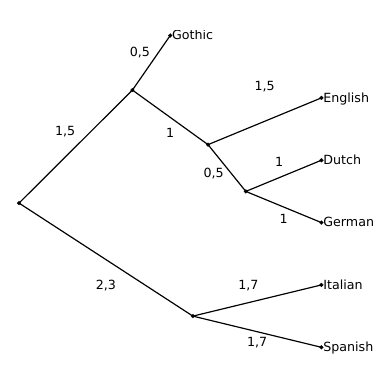

We can extend the `Tree` class from Exercise 5 easily to phylogenetic trees by adding a field `dist` that hold the length of the branch at the root of the tree.

In [ ]:
mutable struct PhyloTree
    name::AbstractString
    dist::Float64
    children::Vector{PhyloTree}
    mother::Union{PhyloTree, Missing}
end

function PhyloTree(name::String=nm, dist=1.0)
    PhyloTree(name, dist, PhyloTree[], missing)
end


The tree shown above can be represented by a `PhyloTree` object `tree` as follows:

In [ ]:
function add_child!(a::PhyloTree,b::PhyloTree)
    push!(a.children, b)
    b.mother = a
end




spanish = PhyloTree("Spanish", 1.7)
italian = PhyloTree("Italian", 1.7)
german = PhyloTree("German", 1.0)
dutch = PhyloTree("Dutch", 1.0)
english = PhyloTree("English", 1.5)
gothic = PhyloTree("Gothic", 0.5)

romance = PhyloTree("7", 2.3)
add_child!(romance, spanish)
add_child!(romance, italian)

cwg = PhyloTree("8", 0.5)
add_child!(cwg, dutch)
add_child!(cwg, german)


wg = PhyloTree("9", 1.0)
add_child!(wg, cwg)
add_child!(wg, english)

germanic = PhyloTree("10", 1.5)
add_child!(germanic, wg)
add_child!(germanic, gothic)


tree = PhyloTree("root", 0.0)
add_child!(tree, romance)
add_child!(tree, germanic)



## Task 1: Print method

The Python package `ete3` has a very useful print method for phylogenetic trees. Our example tree would be printed out as

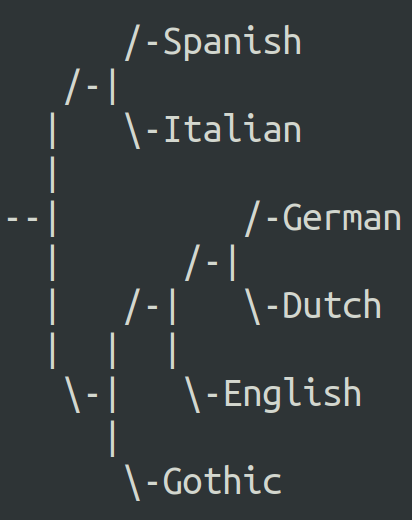

The first task is to implement an equivalent print method for `PhyloTree`.

### Print function

Helper function for `print`.
- Arguments: <br>
`current`: A PhyloTree. <br> 
`prefix`: The two-character prefix of the current leaf node, branch or tree.
- Returns:
A vector of lines to be printed.
The index of the left-most branch connector (relevant for recursive calls).

In [ ]:
function tree_to_lines(current::PhyloTree, prefix::String)
    # Reached a leaf node? Stop the recursion.
    # The vertical centre of a leaf node is the leaf node itself (index 1).
    isempty(current.children) && return ([prefix * current.name], 1)

    lines = []
    # 'Pipe' refers to the vertical lines that connect sibling branches.
    (pipe_start, pipe_end) = (-1, -1)
    uppermost_child = current.children[1]
    lowermost_child = current.children[end]
    for child in current.children
        # Upper branch / lower branch / middle branch (if tree is not binary)
        if child == uppermost_child
            branch_pfx = "/-"
        elseif child == lowermost_child
            branch_pfx = "\\-"
        else
            branch_pfx = "--"
        end

        child_branch = tree_to_lines(child, branch_pfx)
        # Skip all previous lines and get the indices of the lines below(/above)
        # the uppermost(/lowermost) child to mark the beginning(/end) of the
        # vertical sibling connection line.
        if child == uppermost_child
            pipe_start = length(lines) + child_branch[2] + 1
        elseif child == lowermost_child
            pipe_end = length(lines) + child_branch[2] - 1
        end

        append!(lines, child_branch[1])

        # Add a line of vertical space between each pair of node names.
        child != lowermost_child && push!(lines, "")
    end
    # Add whitespace and/or pipes to the left of the branches.
    pipe_centre = Int(floor((pipe_start + pipe_end) / 2))
    for idx in 1:length(lines)
        pfx_start = "  "
        pfx_pipe = " "
        if idx >= pipe_start && idx <= pipe_end
            pfx_pipe = "|"
            # At the vertical centre of the pipe:
            # introduce the current branch with /-, -- or \-.
            idx == pipe_centre && (pfx_start = prefix)
        end
        lines[idx] = pfx_start * pfx_pipe * lines[idx]
    end

    return (lines, pipe_centre)
end

Prints a horizontal representation of a given tree with centered branches.

In [ ]:
function print(tree::PhyloTree)
    for line in tree_to_lines(tree, "--")[1]
        println(line)
    end
end

## Task 2: Compute pairwise distances of the leaves of a tree

The cophenetic distance between two leaves in a phylogenetic tree is the length of the path between those leaves.

Implement a function `cophenetic` that takes a `PhyloTree` argument and returns a data frame containing the cophenetic distances between the leaves.

In the running example, the output should, e.g., be 

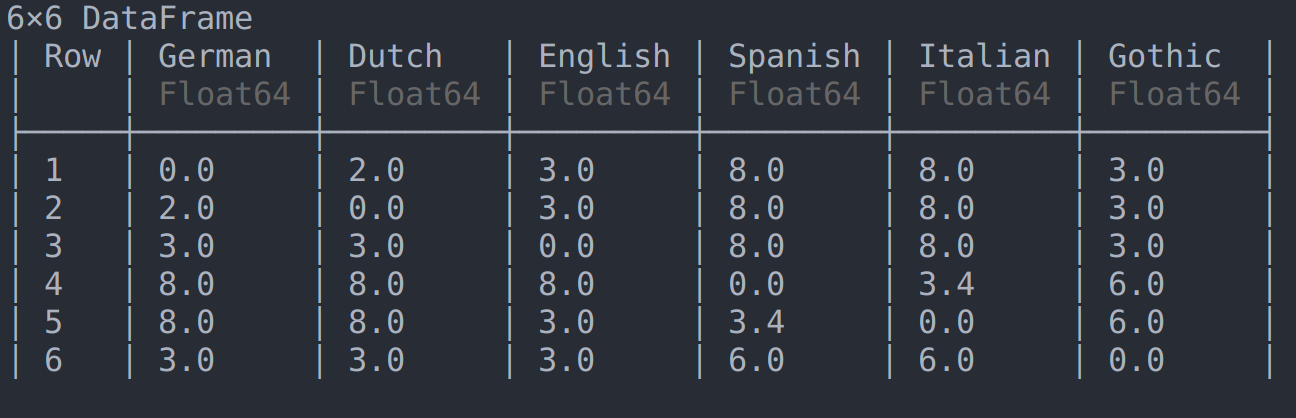

Use the package `DataFrame` for this task.


### Cophenetic function

- A function that calculates the pairwise distances between leafs
- Arguments: <br>
`PhyloTree`: an input tree. <br>
`path`: a stack representing the path from root to the current node (for the recursive call). <br>
`dict`: map storing node name to its tree representation (for the recursive call). <br>
`df`: the distance table to be updated (for the recursive call). <br>
- Returns: <br>
`df`: a `DaraFrame` table with pairwise distances

In [ ]:
function cophenetic(node::PhyloTree, path=PhyloTree[],
                    dict=Dict{String,Array{PhyloTree}}(), df=DataFrame())
    # If the path is empty, we are at the root, so start collecting path entries
    isempty(path) && push!(path,node)
    # If the current node doesn't have children, the node is a leaf
    if isempty(node.children)
        # Current path from root until the leaf is saved in the dictionary
        dict[node.name] = copy(path)
        column_length = length(names(df))
        values = Float64[]
        # For each already existing column (leaf):
        for name in names(df)
            # If they are the same node, the distance is 0.
            if name == node.name
                push!(values, 0.0)
            else
                # Find the lowest common ancestor by getting paths of the
                # current pair from the dictionary and taking the last element
                # of their intersection.
                common_ancestor = first(intersect(
                    OrderedSet(reverse(dict[name])),
                    OrderedSet(reverse(dict[node.name]))))
                cur = node
                sum1 = 0.0
                # Sum of edges from the first path
                while cur != common_ancestor
                    sum1 += cur.dist
                    cur = cur.mother
                end
                cur = dict[name][end]
                sum2 = 0.0
                # Sum of the edges from the second path
                while cur != common_ancestor
                    sum2 += cur.dist
                    cur = cur.mother
                end
                push!(values, sum1 + sum2)
            end
        end
        # Fill the table with symmetric distance values:
        index = column_length + 1
        push!(values, 0.0)
        index != 1 && push!(df, values[begin:index-1])
        insertcols!(df, index, node.name => values[begin:index])

    else
        # Iterate though all children of the current node
        for child in node.children
            # Collect the path furter, continue recurisively.
            push!(path, child)
            cophenetic(child, path, dict, df)
            pop!(path)
        end
    end
    return df
end

## Phylogenetic inference: UPGMA and Neigbor Joining

Distance-based phylogenetic inference is the opposite of the cophenetic function: Starting from a distance matrix, the task is to construct a phylogenetic tree. There are two standard approaches for this:

- UPGMA (https://en.wikipedia.org/wiki/UPGMA)
- Neighbor Joining (https://en.wikipedia.org/wiki/Neighbor_joining)

Write two Julia functions, `upgma` and `nj`, that implement these algorithms. They should take a distance matrix as DataFrame as input and return a `PhyloTree` object. 

### Implementation

- A helper function for `upgma()` and `nj()`.
- Finds the minimum value of the lower triangle in a symmetric matrix.

In [ ]:
function lower_triangle_min(matrix)
    min_value = Inf
    min_row = 0
    min_col = 0
    for i in 2:size(matrix)[1]
        for j in 1:i - 1
            if matrix[i, j] < min_value
                min_value = matrix[i, j]
                min_row = i
                min_col = j
            end
        end
    end
    # Returns a tuple(tuple(index of row, index of column), min value)
    return (min_row, min_col), min_value
end

**UPGMA**
- Constructs a phylogenetic tree from a distance table via the unweighted pair
- group method with arithmetic mean.

In [ ]:
function upgma(df::DataFrame)
    matrix = convert(Matrix{Float64}, df)
    nodes = names(df)
    # A dictionary that maps a name to its corresponding tree, number of
    # children and the sum of branch lengths.
    tree_map = Dict{String, Tuple{PhyloTree, Int64, Float64}}()
    while length(matrix) > 1
        # Find the minimum value of lower triangle:
        (min_row, min_col), min_value = lower_triangle_min(matrix)
        # The distance must be equal for both connected nodes.
        new_dist = min_value / 2
        # Construct tree elements for new nodes.
        # Tf they exist in a map, they are connecting intermediate nodes for
        # which a tree representation already exists.
        # If not, they are leaves, and we create a new tree representation.
        # Store n, n1 and n2 for the number of children in a tree,
        # and sum - the sum of branches divided by two.
        name_a = nodes[min_row]
        name_b = nodes[min_col]
        a = PhyloTree(name_a, new_dist)
        b = PhyloTree(name_b, new_dist)
        (n, n1, n2) = (2, 1, 1)
        if haskey(tree_map, name_a)
            a, n1, sum = tree_map[name_a]
            n += n1 - 1
            # A new distance is determined by half of the matrix distance,
            # minus the existing children's distance.
            a.dist = new_dist - sum
            delete!(tree_map, name_a)
        end
        if haskey(tree_map, name_b)
            b, n2, sum = tree_map[name_b]
            n += n2 - 1
            b.dist = new_dist - sum
            delete!(tree_map, nodes[min_col])
        end
        # Add a new connecting node to the map:
        new_name = a.name * "-" * b.name
        connect = PhyloTree(new_name, 0.0)
        add_child!(connect, a)
        add_child!(connect, b)
        tree_map[new_name] = (connect, n, new_dist)
        nodes[min_col] = new_name
        deleteat!(nodes, min_row)

        # Collect the new distances.
        new_row = Float64[]
        for (i, val) in enumerate(matrix[min_row, :])
            if i == min_col
                push!(new_row, 0.0)
            elseif i != min_row
                # Average the distance
                push!(new_row,
                      (matrix[min_row, i] * n1 + matrix[min_col, i] * n2) / (n1 + n2))
            end
        end
        # Update matrix symmetrically.
        # Remove a column and a row, replace another column and a row with new values.
        matrix = matrix[1:end .!= min_row, 1:end .!= min_row]
        matrix[min_col, :] = new_row
        matrix[:, min_col] = new_row
    end
    # The only remaining element of the map is the root of the tree:
    tree = collect(values(tree_map))[1][1]
    tree.name = "root"
    return tree
end

**Neighbor Joining**
- Constructs a phylogenetic tree from a distance table via neighbour joining.
- Note that even if the given cophenetic distance table allows for the construction of several different phylogenetic trees, this method returns only a single possible solution.

In [ ]:
function nj(dist::DataFrame)
    dist = deepcopy(dist)
    # Keep track of all branches to assemble a full tree.
    branches = Dict{String, PhyloTree}(
        lang => PhyloTree(lang, -1.0) for lang in names(dist))

    while size(dist)[1] > 1
        langs = names(dist)
        n = length(langs)
        # Construct the lower triangle matrix Q.
        q = DataFrame(fill(Union{Float64, Missing}, n), langs, n)
        for i in 2:n
            dist_i = sum([dist[i, k] for k in 1:n])
            for j in 1:i-1
                dist_j = sum([dist[j, k] for k in 1:n])
                q[i, j] = (n - 2) * dist[i, j] - dist_i - dist_j
            end
        end

        # The lowest value within Q shows the pair of languages that should be
        # merged next.
        merge_idx = lower_triangle_min(q)[1]
        merge_idx = sort([i for i in merge_idx])
        (f, g) = merge_idx

        # Determine the distance of the two branches that should be merged
        # to the node where they are joined together.
        dist_fg = dist[f, g]
        (lang1, lang2) = (langs[f], langs[g])
        (dist_f, dist_g) = (0.0, 0.0)
        for k in 1:length(langs)
            dist_f += dist[f, k]
            dist_g += dist[g, k]
        end
        if n > 2
            branches[lang1].dist = 0.5 * dist_fg +
                                   (1 / (2 * (n - 2))) * (dist_f - dist_g)
        else
            # Avoid dividing by 0 in the second part of the equation.
            # dist_f - dist_g = 0 in that case, anyway.
            branches[lang1].dist = 0.5 * dist_fg
        end
        branches[lang2].dist = dist_fg - branches[lang1].dist

        # Update the collection of tree branches.
        new_name = lang1 * "-" * lang2
        branch = PhyloTree(new_name, 0.0)
        add_child!(branch, branches[lang1])
        add_child!(branch, branches[lang2])
        delete!(branches, lang1)
        delete!(branches, lang2)
        branches[new_name] = branch

        # Find the distances from the newly joint node to all other branches.
        col = Array{Union{Missing, Float64},1}(undef, length(langs) + 1)
        col[1] = 0
        for k in 1:length(langs)
            (k in merge_idx) && continue
            col[k + 1] = 0.5 * (dist[f, k] + dist[g, k] - dist_fg)
        end

        # Update the distance matrix: remove the now deprecated entries and add
        # the row and column vector of the joint node.
        deleteat!(col, [f + 1, g + 1])
        delete!(dist, merge_idx)  # remove rows
        select!(dist, Not(merge_idx))  # remove cols
        insertcols!(dist, 1, new_name => col[2:end])
        foreach((c, v) -> insert!(c, 1, v), eachcol(dist), col)
    end

    # Only the complete phylogenetic tree is left in the branch collection
    # at this point.
    return collect(values(branches))[1]
end

### Testing

Test your functions by comparing them to the function `upgma` and `NJ` from the R-library `phangorn`. Construct a batch of random distance matrices, apply your functions and the corresponding `phangorn` functions to them and check that the results are equivalent.

When testing equivalence for Neighbor Joining, be aware that the correct solution is not unique. Two solutions are equivalent if they define the same cophenetic matrix.

Also note that the order of sister nodes in a phylogenetic tree is inessential. Two trees that are formally different might represent the same correct solution for UPGMA if they only differ with respect to the order of nodes.

You can consult my slides at http://www.sfs.uni-tuebingen.de/~gjaeger/lehre/websiteWBGT/slides/phylogeneticTrees_wbgt.pdf as background reading material.

**Helper functions**

Returns a copy of a given dataframe with (alphabetically) sorted column names and correspondingly sorted cells.

In [ ]:
function sort_dataframe(df::DataFrame)
    sorted_indices = sortperm(names(df))
    # Already sorted?
    (sorted_indices == [i for i in 1:length(names(df))]) && return deepcopy(df)
    sorted = deepcopy(df[!, sorted_indices])
    for i in 1:length(names(df))
        sorted[!, i] = sorted[!, i][sorted_indices]
    end
    return sorted
end

Returns whether two dataframes are (approximately) identical.

In [ ]:
function equivalent_tables(x::DataFrame, y::DataFrame)
    # isapprox returns a table with a 1 for each (approximately) identical cell
    # and a 0 for each different cell.
    for col in eachcol(isapprox.(sort_dataframe(x), sort_dataframe(y)))
        (0 in col) && return false
    end
    return true
end

- Generates random distance matrices and uses them to compare our tree-joining methods to the implementations in the R library `phangorn`.
- Arguments: <br>
`n_trials`: number of trial runs <br>
`mode`: either: "*upgma*" or "*nj*" <br>
`min_taxa`, `max_taxa`: boundaries for generating random tree <br>
`verbose`: If `true`, prints an update for each test.
- Returns whether **all** tests passed.

In [ ]:
function random_tests(n_trials::Int, mode::String, min_taxa=3, max_taxa=20,
                      verbose=false)
    for trial in 1:n_trials
        # Create a random distance table. The table is inferred from a random
        # tree in order to guarantee that the distances can actually be used to
        # infer a tree without any triangle inequalities (e.g. if two nodes
        # A and B are both very similar to node C but simultaneously very
        # dissimilar to one another).
        root = PhyloTree("root", 0.0)
        queue = [root]
        (n_nodes, n_leaves) = (1, 1)
        while length(queue) > 0 && n_leaves < max_taxa
            branch = popfirst!(queue)
            if (n_leaves < min_taxa) || (rand(1:2) > 1)
                for i in 1:2
                    child = PhyloTree(string(n_nodes), rand(1:0.1:20))
                    add_child!(branch, child)
                    push!(queue, child)
                    n_nodes += 1
                end
                # Turn a leaf node into a middle node, add two new leaves.
                n_leaves += 1
            end
        end
        matrix = cophenetic(root)

        # In R, create a tree and get its cophenetic matrix.
        langs = names(matrix)
        flat = convert(Matrix, matrix)[:]
        n_cols = length(langs)
        @rput n_cols
        @rput langs
        @rput flat
        R"library(phangorn)"
        R"d <-as.dist(matrix(c(flat), byrow=T, nrow=n_cols,
                             dimnames=list(langs, langs)))"
        if mode == "nj"
            R"tree <- nj(d)"
        elseif mode == "upgma"
            R"tree <- upgma(d)"
        end
        R"coph <- cophenetic(tree)[langs, langs]"
        @rget coph
        coph_r = DataFrame([langs[i] => coph[:, i] for i in 1:n_cols])

        # Construct the tree and cophenetic matrix with our code.
        if mode == "nj"
            tree = nj(matrix)
        elseif mode == "upgma"
            tree = upgma(matrix)
        end
        coph_jl = cophenetic(tree)

        # Check for equivalence.
        match = equivalent_tables(coph_r, coph_jl)
        verbose && println("Trial $trial ($n_cols taxa): $match")
        if !match
            println("TEST FAILED")
            return false
        end
    end
    println("ALL TESTS PASSED")
    return true
end

**Testing**

In [ ]:
println("The original tree:\n")
print(tree)
println("\n\nThe corresponding cophenetic table:\n")
distance_table = cophenetic(tree)
show(distance_table)
println("\n\nThe tree constructed via UPGMA:\n")
upgma_tree = upgma(distance_table)
print(upgma_tree)
println("\n\nThe tree constructed via Neighbour Joining:\n")
nj_tree = nj(distance_table)
print(nj_tree)
println("\n\nThe given tree is not ultrametric (e.g. Gothic is closer to the" *
        "root than Spanish).")
println("Therefore, the cophenetic matrix *cannot* be retrieved from the UPGMA tree:")
@show equivalent_tables(distance_table, cophenetic(upgma_tree))
println("But it *can* be fully retrieved from the NJ tree:")
@show equivalent_tables(distance_table, cophenetic(nj_tree))
println("\n\nComparing our UPGMA method to that in phangorn (R):\n")
random_tests(500, "upgma")
println("\n\nComparing our NJ method to that in phangorn (R):\n")
random_tests(500, "nj")